In [28]:
import numpy as np
import cv2
import os
import pandas as pd
from collections import Counter as cnt
import matplotlib.pyplot as plt
import torch
import csv
from scipy.stats import chi2_contingency
import pickle
from scipy import stats

#import module
from Mymodule.ModelHandler import *
from Mymodule.Utils import *
from Mymodule.GradCam import *
from Mymodule.BatchHandler import *
from collections import Counter as cnt
from torchvision import transforms
from keras import Sequential
from torch import nn

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from torch import optim

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

## Prepare Dataset

In [32]:
image_root = {}
image_root['train'] = f'./Dataset/Train_image/'
image_root['test'] = f'./Dataset/Test_image/'

clinic_df_path = './Dataset/Excel/230608_clinic_datas.xlsx'
expert_df_path = './Dataset/Excel/230608_expert_diagnosis.xlsx'

clinic_df = pd.read_excel(clinic_df_path).dropna()
clinic_df.loc[clinic_df["SEX"] == "M", "SEX"] = 1
clinic_df.loc[clinic_df["SEX"] == "F", "SEX"] = 0
clinic_df.loc[clinic_df["SEX"] == '  F', "SEX"] = 0
expert_df = pd.read_excel(expert_df_path).drop(columns = ('Unnamed: 8')).dropna()

print("columns of clinic_data : ", clinic_df.columns)
print("columns of expert_diagnosis : ", expert_df.columns)

columns of clinic_data :  Index(['ID', 'SEX', 'AGE', 'VAS_UPTO10', 'TMJ_PAIN', 'Direction', 'ONSET',
       'TMJ_noise'],
      dtype='object')
columns of expert_diagnosis :  Index(['ID', '이름', '성별 ', '나이', 'Lt. effusion (0-없음, 1-있음)',
       'Rt. (0-없음, 1-있음)', 'Lt. effusion (0-없음, 1-있음): 영상의학과 전문의 ',
       'Rt. (0-없음, 1-있음).1'],
      dtype='object')


In [34]:
complete_data_path = "./Dataset/complete_dataset.pickle"

x_start = 45
y_start = 100
x_end = x_start + 300
y_end = y_start + 400

#for making dataset...
MRIs = ['PD','T2']
stages = ['train', 'val', 'test']
categorys = ['image','clinic', 'pt_no', 'label','expert']
if not os.path.isfile(complete_data_path):
    data = {}
    for MRI in MRIs:
        data[MRI] = {}
        for stage in stages: 
            data[MRI][stage] = {}
            for category in categorys:
                data[MRI][stage][category] = []

            if stage == 'val' : continue    

            mri_image_root = os.path.join(image_root[stage],MRI)

            for image in os.listdir(mri_image_root):
                if not image[-3:] == 'png': continue

                pt_no,side,age,sex,label = image.split('_') 
                pt_no,age,label = int(pt_no), int(age), int(label[0])
                if sex == 'M' : sex = 1
                elif sex == 'F' : sex = 0
                else : sex = np.nan
                
                clinic_data = clinic_df[clinic_df['ID']==pt_no].values

                image_path = os.path.join(mri_image_root,image)
                if stage == 'train' : reshaped_image = cv2.resize(cv2.imread(image_path, 0)[x_start:x_end, y_start:y_end],(140,140))
                if stage == 'test'  : reshaped_image = cv2.resize(cv2.imread(image_path, 0),(140,140))
                reshaped_image = np.dstack((reshaped_image,reshaped_image,reshaped_image))

                data[MRI][stage]['image'].append(reshaped_image)
                if clinic_data.shape[0]:
                    clinic_data[0][1], clinic_data[0][2] = sex, age
                    data[MRI][stage]['clinic'].append(np.array(clinic_data[0][1:],dtype = 'float16'))
                else : data[MRI][stage]['clinic'].append([sex, age, np.nan, np.nan, np.nan,np.nan,np.nan])        
                data[MRI][stage]['pt_no'].append(pt_no)
                data[MRI][stage]['label'].append(label)
                
                if stage == 'test':
                    expert = expert_df[expert_df['ID'] == pt_no]
                    if   side == 'L' : data[MRI][stage]['expert'].append(expert['Lt. effusion (0-없음, 1-있음): 영상의학과 전문의 '].values[0]) 
                    elif side == 'R' : data[MRI][stage]['expert'].append(expert['Rt. (0-없음, 1-있음).1'].values[0]) 
    

            data[MRI][stage]['clinic'], data[MRI][stage]['image'], data[MRI][stage]['label'], data[MRI][stage]['expert'] = np.array(data[MRI][stage]['clinic']), np.array(data[MRI][stage]['image']), np.array(data[MRI][stage]['label']).reshape(-1,1), np.array(data[MRI][stage]['expert']).reshape(-1,1)

        data[MRI]['train']['pt_no'],data[MRI]['val']['pt_no'], _, _     = train_test_split(data[MRI]['train']['pt_no'],data[MRI]['train']['label'], test_size=0.2, random_state=32, stratify=data[MRI]['train']['label'])
        data[MRI]['train']['clinic'],data[MRI]['val']['clinic'], _, _   = train_test_split(data[MRI]['train']['clinic'],data[MRI]['train']['label'], test_size=0.2, random_state=32, stratify=data[MRI]['train']['label'])
        data[MRI]['train']['image'],data[MRI]['val']['image'],data[MRI]['train']['label'],data[MRI]['val']['label'] = train_test_split(data[MRI]['train']['image'], data[MRI]['train']['label'], test_size=0.2, random_state=32, stratify=data[MRI]['train']['label'])    

    #save data
    with open(complete_data_path,'wb') as fw:
        pickle.dump(data, fw)

elif os.path.isfile(complete_data_path):
    # load data
    with open(complete_data_path, 'rb') as fr:
        data = pickle.load(fr)

# show data
print(data.keys())

dict_keys(['PD', 'T2'])


### Model preparation

In [35]:
device = torch.device('cuda:0')

epochs = 20
milestone = [epochs-10, epochs-6]
min_epoch = 6
batch = 32
lr = 1e-4

model_name = 'vgg16'
#model_name = 'resnet50'

### Training

In [36]:
#for transformation
#... clinic - learning_strategy - mri - group
#... first... without clinic.... to make model...
train_strategies = ['finetuning','fromscratch','freeze']

for MRI in MRIs:
    for train_strategy in train_strategies:
        model_save_path = f'./Model_for_effusion/{model_name}_{MRI}_{train_strategy}.pt'
        
        if not os.path.isfile(model_save_path):
            train_x, val_x, test_x = data[MRI]['train']['image'], data[MRI]['val']['image'], data[MRI]['test']['image']
            train_y, val_y, test_y  = data[MRI]['train']['label'], data[MRI]['val']['label'], data[MRI]['test']['label']

            randrot, randvert, randaff = [-15,15], 0.15, [0.1, 1]
            train_transform = [transforms.RandomRotation(randrot), transforms.RandomVerticalFlip(p=randvert), transforms.RandomAffine(0, translate=randaff)]
            train_loader = GetLoader(train_transform, train_x, train_y, batch=batch, test=False)
            val_loader = GetLoader([], val_x, val_y, batch=len(val_y), test=True)
            test_loader = GetLoader([], test_x, test_y, batch=len(test_y), test=True)      

            if train_strategy == 'finetuning'  : model = get_model(model_name, device, pretrained=True, freeze = False)
            if train_strategy == 'fromscratch' : model = get_model(model_name, device, pretrained=False, freeze = False)
            if train_strategy == 'freeze'      : model = get_model(model_name, device, pretrained=False, freeze = True)
            optimizer = optim.Adam(model.parameters(), lr=lr)
            scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestone)

            history_t_loss, history_loss, history_auc, history_test_auc, history_train_auc = \
            train_convnet(model, device, train_loader, val_loader, test_loader, lr, epochs, model_save_path,
            optimizer=optimizer, scheduler=scheduler, min_epoch=min_epoch, pos_weight=0, save_by='val_loss', out = True)

            bestepoch = np.argmax(history_auc[min_epoch-1:]) + min_epoch
            print("best epoch : ", bestepoch, " train auc : ",format(history_train_auc[bestepoch-1],".4f"),  " valid auc : ", format(history_auc[bestepoch-1],".4f"), "test auc : ", format(history_test_auc[bestepoch-1],".4f"))
            
        else : print(f'{model_name}_{MRI}_{train_strategy} already exists')

vgg16_PD_finetuning already exists
vgg16_PD_fromscratch already exists
vgg16_PD_freeze already exists
vgg16_T2_finetuning already exists
vgg16_T2_fromscratch already exists
vgg16_T2_freeze already exists


### Getting Probability from VGG16 Model

In [37]:
vgg16proba_with_clinicdata_path = './Dataset/vgg16proba_with_clinicdata'
#vgg16proba_with_clinicdata_path = './Dataset/resnet50proba_with_clinicdata'

if not os.path.isfile(vgg16proba_with_clinicdata_path):
    vgg16proba_with_clinicdata = {}

    sig = torch.nn.Sigmoid()
    for MRI in MRIs:
        vgg16proba_with_clinicdata[MRI] = {}
        for train_strategy in train_strategies:
            vgg16proba_with_clinicdata[MRI][train_strategy] = {}
            print(f'MRI_{MRI}, train_strategy_{train_strategy}')
            model_save_path = f'./Model_for_effusion/{model_name}_{MRI}_{train_strategy}.pt'

            model = get_model(model_name, device, pretrained=True)    
            model.load_state_dict(torch.load(model_save_path))
            model.eval()

            train_x,      val_x,      test_x      = data[MRI]['train']['image'] , data[MRI]['val']['image'] , data[MRI]['test']['image']
            train_clinic, val_clinic, test_clinic = data[MRI]['train']['clinic'], data[MRI]['val']['clinic'], data[MRI]['test']['clinic']
            train_y,      val_y,      test_y      = data[MRI]['train']['label'] , data[MRI]['val']['label'] , data[MRI]['test']['label']

            randrot, randvert, randaff = [-15,15], 0.15, [0.1, 1]
            train_transform = [transforms.RandomRotation(randrot), transforms.RandomVerticalFlip(p=randvert), transforms.RandomAffine(0, translate=randaff)]

            train_loader = GetLoader(train_transform, train_x, train_y, batch=batch, test=True)
            val_loader = GetLoader([], val_x, val_y, batch=len(val_y), test=True)
            test_loader = GetLoader([], test_x, test_y, batch=len(test_y), test=True)      

            # for getting probabilities from trained vgg16 models.
            with torch.no_grad():
                for stage in stages:
                    vgg16proba_with_clinicdata[MRI][train_strategy][stage] = {}
                    if stage == 'train' : loader = train_loader
                    if stage == 'val'   : loader = val_loader
                    if stage == 'test'  : loader = test_loader
                    check = 0
                    for image, label in loader:
                        image, label = image.to(device), label.to(device)
                        logit = model(image)
                        proba, label = sig(logit), label.float()
                        if check ==0: probas, logits, labels = proba, logit,label
                        if check ==1: probas, logits, labels = torch.cat([probas, proba]), torch.cat([logits, logit]), torch.cat([labels, label])
                        check = 1
                    vgg16proba_with_clinicdata[MRI][train_strategy][stage]['proba'], vgg16proba_with_clinicdata[MRI][train_strategy][stage]['logit'], vgg16proba_with_clinicdata[MRI][train_strategy][stage]['label'] = probas.cpu().numpy(), logits.cpu().numpy(), labels.cpu().numpy()                
                    vgg16proba_with_clinicdata[MRI][train_strategy][stage]['clinic'] = data[MRI][stage]['clinic']
                    vgg16proba_with_clinicdata[MRI][train_strategy][stage]['expert'] = data[MRI][stage]['expert']

    #save data
    with open(vgg16proba_with_clinicdata_path,'wb') as fw:
        pickle.dump(vgg16proba_with_clinicdata, fw)

elif os.path.isfile(vgg16proba_with_clinicdata_path):
    with open(vgg16proba_with_clinicdata_path, 'rb') as fr:
        vgg16proba_with_clinicdata = pickle.load(fr)
        
vgg16proba_with_clinicdata.keys()

dict_keys(['PD', 'T2'])

### Training 3 Layer shallow deep learning model

In [38]:
# Is it trustable...??....
# need to check logistic regression....?
model_name = 'shallow_three_layer'
#model_name = 'shallow_three_layer_resnet50'

epochs = 100
milestone = [epochs-10, epochs-6]
min_epoch = 5
batch = 512
lr = 1
scalar = StandardScaler().fit_transform

for MRI in MRIs:
    model_save_path = f'./Model_for_effusion/{model_name}_{MRI}.pt'
    if not os.path.isfile(model_save_path):
        train_proba, val_proba, test_proba    = vgg16proba_with_clinicdata[MRI]['finetuning']['train']['proba'], vgg16proba_with_clinicdata[MRI]['finetuning']['val']['proba'], vgg16proba_with_clinicdata[MRI]['finetuning']['test']['proba']
        train_clinic, val_clinic, test_clinic = vgg16proba_with_clinicdata[MRI]['finetuning']['train']['clinic'], vgg16proba_with_clinicdata[MRI]['finetuning']['val']['clinic'], vgg16proba_with_clinicdata[MRI]['finetuning']['test']['clinic']
        train_x, val_x, test_x = np.concatenate([train_proba, train_clinic],axis = -1), np.concatenate([val_proba, val_clinic],axis = -1), np.concatenate([test_proba, test_clinic],axis = -1)
        train_y, val_y, test_y = vgg16proba_with_clinicdata[MRI]['finetuning']['train']['label'], vgg16proba_with_clinicdata[MRI]['finetuning']['val']['label'], vgg16proba_with_clinicdata[MRI]['finetuning']['test']['label']
        temp_train_x, temp_val_x, temp_test_x = [], [], []
        temp_train_y, temp_val_y, temp_test_y = [], [], []
        for i in range(len(train_x)):
            if not np.isnan(train_x[i]).any() : 
                temp_train_x.append(train_x[i])
                temp_train_y.append(train_y[i])
        for i in range(len(val_x)):
            if not np.isnan(val_x[i]).any() : 
                temp_val_x.append(val_x[i])
                temp_val_y.append(val_y[i])
        for i in range(len(test_x)):
            if not np.isnan(test_x[i]).any() : 
                temp_test_x.append(test_x[i])
                temp_test_y.append(test_y[i])
        train_x, val_x, test_x  = scalar(np.array(temp_train_x)), scalar(np.array(temp_val_x)), scalar(np.array(temp_test_x))
        train_y, val_y, test_y  = np.array(temp_train_y), np.array(temp_val_y), np.array(temp_test_y)

        train_loader = GetLoader_for_clinic(train_x, train_y, batch=batch, test=False)
        val_loader   = GetLoader_for_clinic(val_x, val_y, batch=len(val_y), test=True)
        test_loader  = GetLoader_for_clinic(test_x, test_y, batch=len(test_y), test=True)      

        model = get_model(model_name, device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestone)

        history_t_loss, history_loss, history_auc, history_test_auc, history_train_auc = \
        train_convnet(model, device, train_loader, val_loader, test_loader, lr, epochs, model_save_path,
        optimizer=optimizer, scheduler=scheduler, min_epoch=min_epoch, pos_weight=0, save_by='val_loss', out = False)

        bestepoch = np.argmax(history_auc[min_epoch-1:]) + min_epoch
        print("best epoch : ", bestepoch, " train auc : ",format(history_train_auc[bestepoch-1],".4f"),  " valid auc : ", format(history_auc[bestepoch-1],".4f"), "test auc : ", format(history_test_auc[bestepoch-1],".4f"))

    else : print(f'{model_name}_{MRI} already exists')

shallow_three_layer_PD already exists
shallow_three_layer_T2 already exists


### Getting probability from Shallow Three Layer model

In [39]:
STLproba_with_clinicdata_path = './Dataset/STLproba_with_clinicdata'
model_name = 'shallow_three_layer'

#STLproba_with_clinicdata_path = './Dataset/STLproba_with_clinicdata_resnet50'
#model_name = 'shallow_three_layer_resnet50'


if not os.path.isfile(STLproba_with_clinicdata_path):
    STLproba_with_clinicdata = {}
    sig = torch.nn.Sigmoid()
    
    for MRI in MRIs:
        STLproba_with_clinicdata[MRI] = {}
        model_save_path = f'./Model_for_effusion/{model_name}_{MRI}.pt'
        model = get_model(model_name, device, pretrained=True)    
        model.load_state_dict(torch.load(model_save_path))
        model.eval()

        train_proba, val_proba, test_proba    = vgg16proba_with_clinicdata[MRI]['finetuning']['train']['proba'], vgg16proba_with_clinicdata[MRI]['finetuning']['val']['proba'], vgg16proba_with_clinicdata[MRI]['finetuning']['test']['proba']
        train_clinic, val_clinic, test_clinic = vgg16proba_with_clinicdata[MRI]['finetuning']['train']['clinic'], vgg16proba_with_clinicdata[MRI]['finetuning']['val']['clinic'], vgg16proba_with_clinicdata[MRI]['finetuning']['test']['clinic']
        train_x, val_x, test_x = np.concatenate([train_proba, train_clinic],axis = -1), np.concatenate([val_proba, val_clinic],axis = -1), np.concatenate([test_proba, test_clinic],axis = -1)
        train_y, val_y, test_y = vgg16proba_with_clinicdata[MRI]['finetuning']['train']['label'], vgg16proba_with_clinicdata[MRI]['finetuning']['val']['label'], vgg16proba_with_clinicdata[MRI]['finetuning']['test']['label']
        temp_train_x, temp_val_x, temp_test_x = [], [], []
        temp_train_y, temp_val_y, temp_test_y = [], [], []
        
        for i in range(len(train_x)):
            if not np.isnan(train_x[i]).any() : 
                temp_train_x.append(train_x[i])
                temp_train_y.append(train_y[i])
        for i in range(len(val_x)):
            if not np.isnan(val_x[i]).any() : 
                temp_val_x.append(val_x[i])
                temp_val_y.append(val_y[i])
        for i in range(len(test_x)):
            if not np.isnan(test_x[i]).any() : 
                temp_test_x.append(test_x[i])
                temp_test_y.append(test_y[i])
        
        for stage in stages: STLproba_with_clinicdata[MRI][stage] = {}
        
        STLproba_with_clinicdata[MRI]['train']['clinic'], STLproba_with_clinicdata[MRI]['val']['clinic'], STLproba_with_clinicdata[MRI]['test']['clinic'] = np.array(temp_train_x)[:,1:], np.array(temp_val_x)[:,1:], np.array(temp_test_x)[:,1:]
        train_x, val_x, test_x  = scalar(np.array(temp_train_x, dtype ='float32')), scalar(np.array(temp_val_x, dtype ='float32')), scalar(np.array(temp_test_x, dtype ='float32'))
        train_y, val_y, test_y  = np.array(temp_train_y), np.array(temp_val_y), np.array(temp_test_y)

        train_loader = GetLoader_for_clinic(train_x, train_y, batch=batch, test=True)
        val_loader   = GetLoader_for_clinic(val_x, val_y, batch=len(val_y), test=True)
        test_loader  = GetLoader_for_clinic(test_x, test_y, batch=len(test_y), test=True)      

        # for getting probabilities from trained vgg16 models.
        with torch.no_grad():
            for stage in stages:
                if stage == 'train' : loader = train_loader
                if stage == 'val'   : loader = val_loader
                if stage == 'test'  : loader = test_loader
                check = 0
                for feature, label in loader:
                    feature, label = feature.to(device), label.to(device)
                    logit = model(feature)
                    proba, label = sig(logit), label.float()
                    if check ==0: probas, logits, labels = proba, logit,label
                    if check ==1: probas, logits, labels = torch.cat([probas, proba]), torch.cat([logits, logit]), torch.cat([labels, label])
                    check = 1
                STLproba_with_clinicdata[MRI][stage]['proba'], STLproba_with_clinicdata[MRI][stage]['logit'], STLproba_with_clinicdata[MRI][stage]['label'] = probas.cpu().numpy(), logits.cpu().numpy(), labels.cpu().numpy()                
                STLproba_with_clinicdata[MRI][stage]['expert'] = vgg16proba_with_clinicdata[MRI]['finetuning'][stage]['expert']
                

    #save data
    with open(STLproba_with_clinicdata_path,'wb') as fw:
        pickle.dump(STLproba_with_clinicdata, fw)

elif os.path.isfile(STLproba_with_clinicdata_path):
    with open(STLproba_with_clinicdata_path, 'rb') as fr:
        STLproba_with_clinicdata = pickle.load(fr)
        
STLproba_with_clinicdata.keys()

dict_keys(['PD', 'T2'])

In [40]:
def get_filtered_result(clinic,proba,label,expert, filter_standard = 'sexage'):
    temp_proba, temp_label, temp_clinic, temp_expert = [], [], [], []
    for i in range(len(clinic)):
        sex, age = clinic[i][0],clinic[i][1]
        if (filter_standard == 'sexage' and not np.isnan(clinic[i][0:2]).any()) or (filter_standard == 'allclinic' and not np.isnan(clinic[i][:]).any()):
            targeted = False
            if group == 'AGE1'   and (age <= 20): targeted = True
            if group == 'AGE2'   and (age >= 21 and age <= 40): targeted = True
            if group == 'AGE3'   and (age >= 41 and age <= 60): targeted = True
            if group == 'AGE4'   and (age >= 61): targeted = True
            if group == 'FEMALE' and (sex == 0): targeted = True
            if group == 'MALE'   and (sex == 1): targeted = True
            if targeted == True:
                temp_proba.append(proba[i])
                temp_label.append(label[i])
                temp_clinic.append(clinic[i])
                temp_expert.append(expert[i])
    proba = np.array(temp_proba)
    label = np.array(temp_label)
    clinic = np.array(temp_clinic)
    expert = np.array(temp_expert)
    return clinic, proba, label, expert

### Assessment with figures

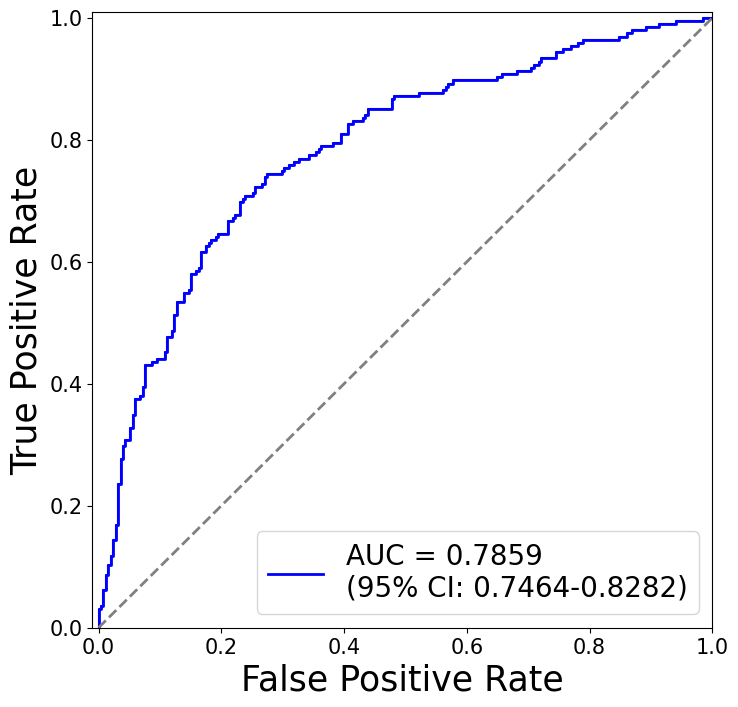

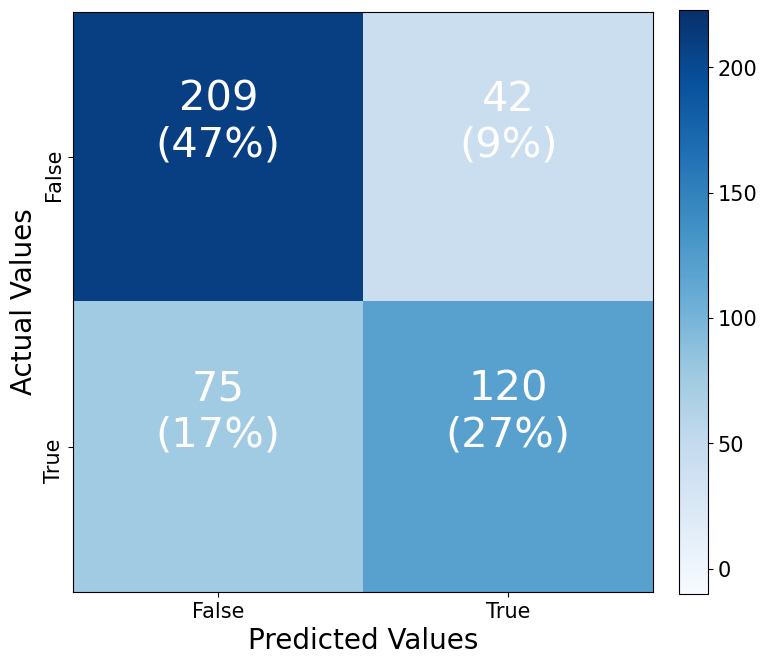

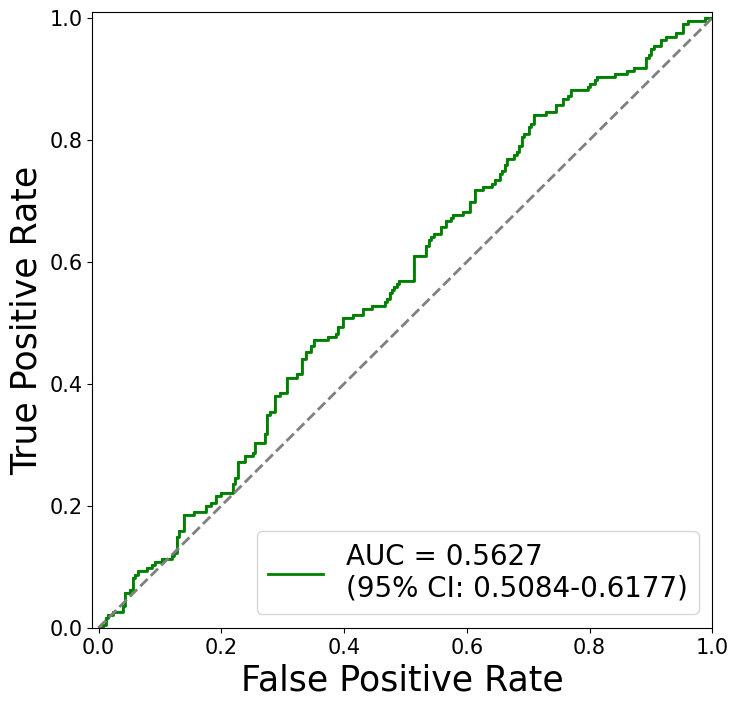

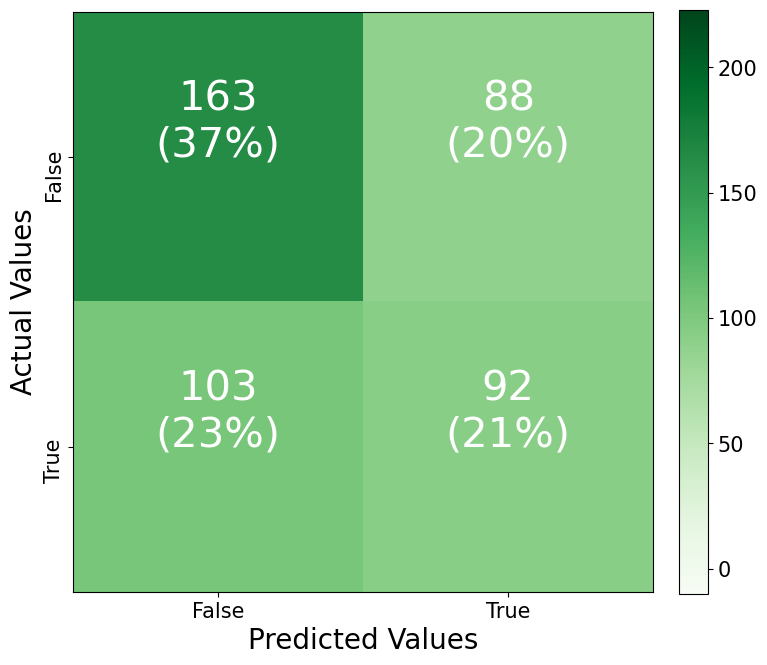

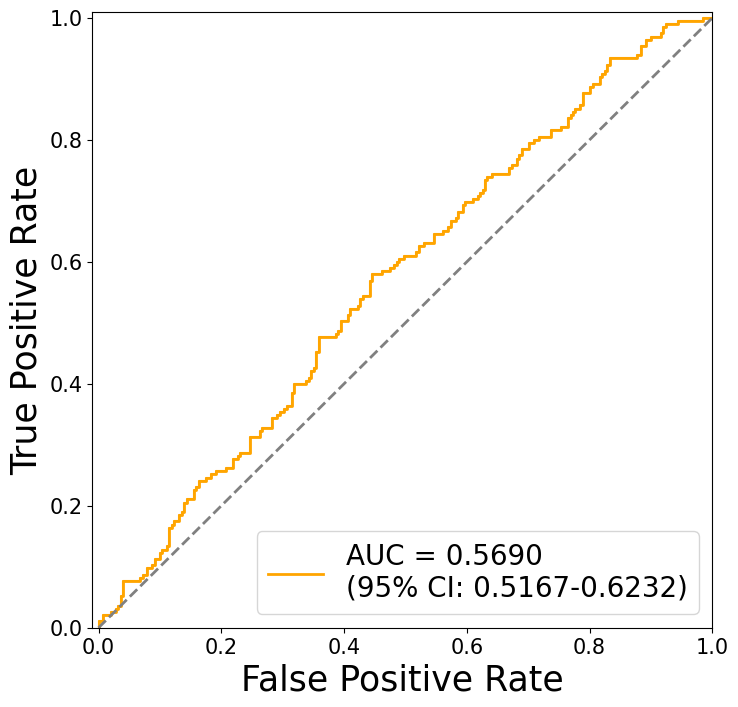

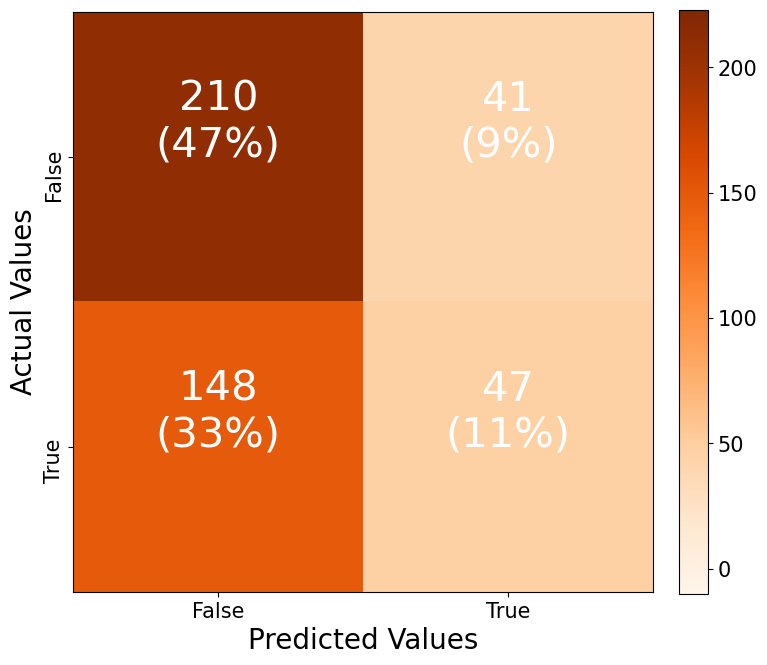

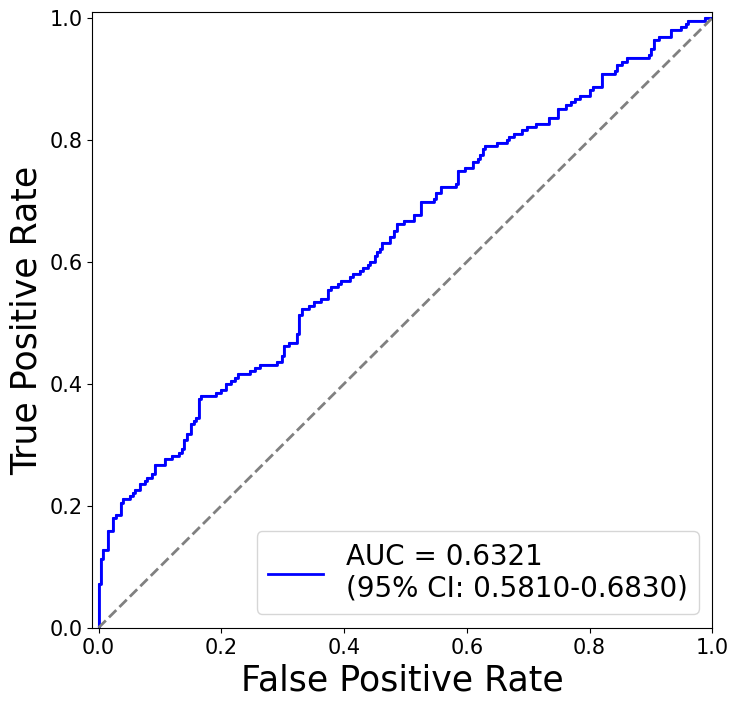

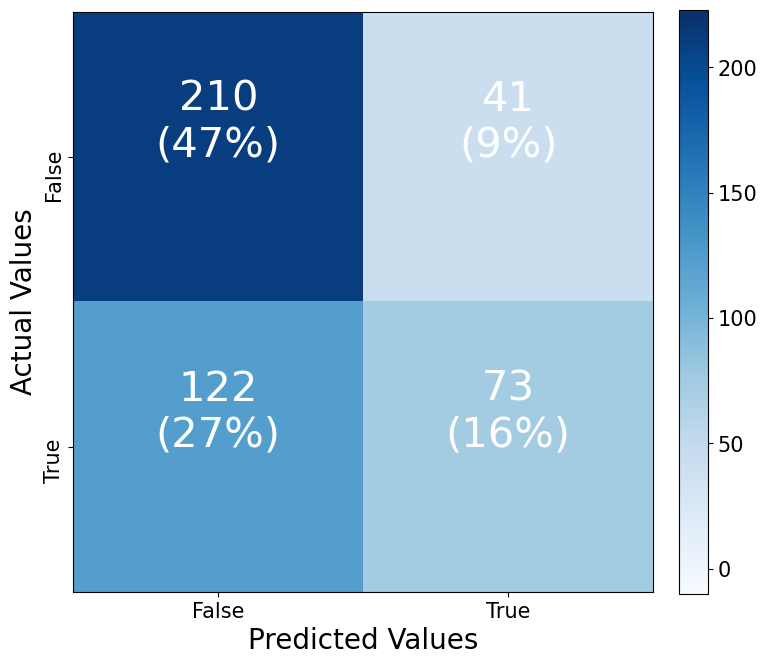

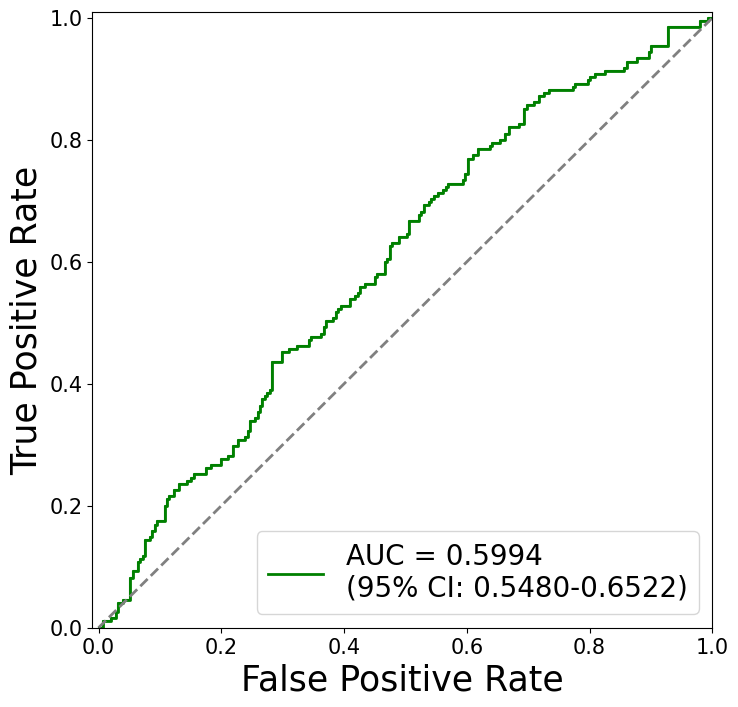

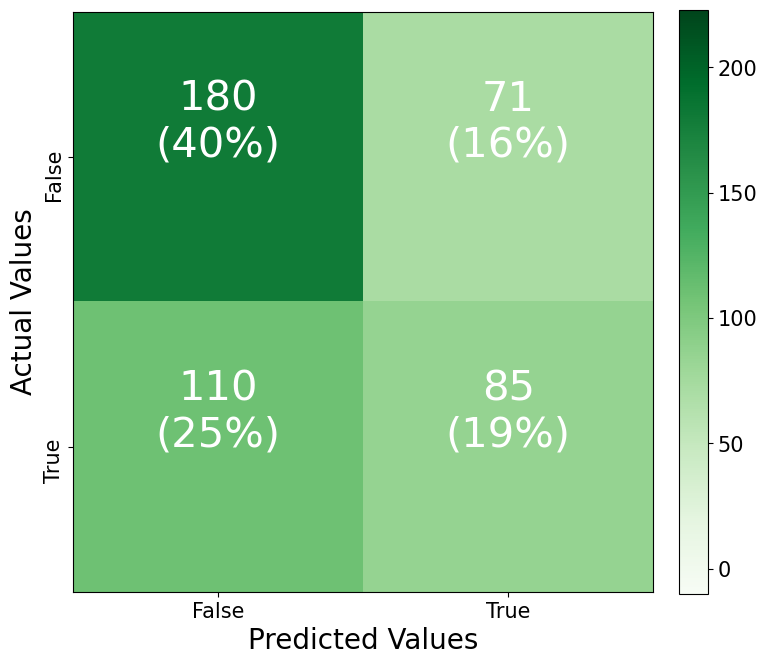

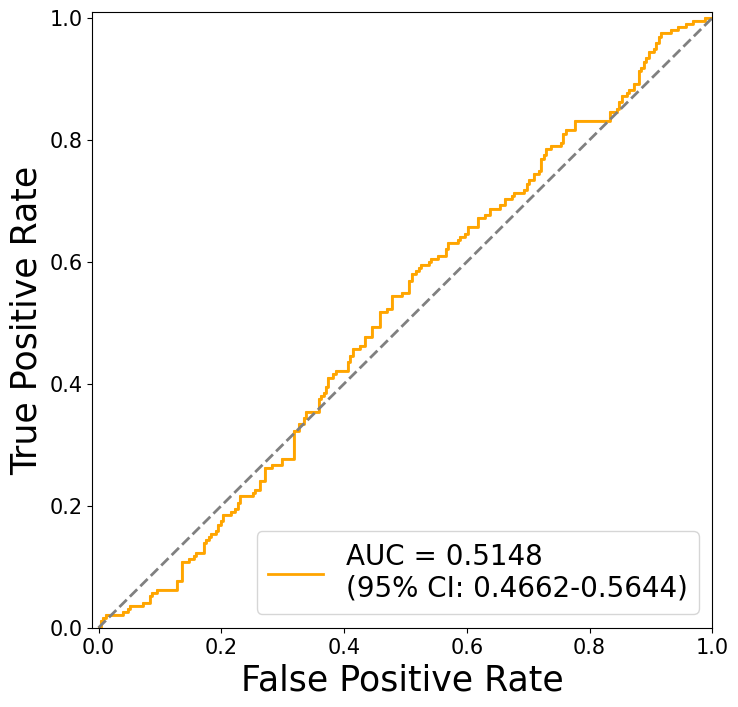

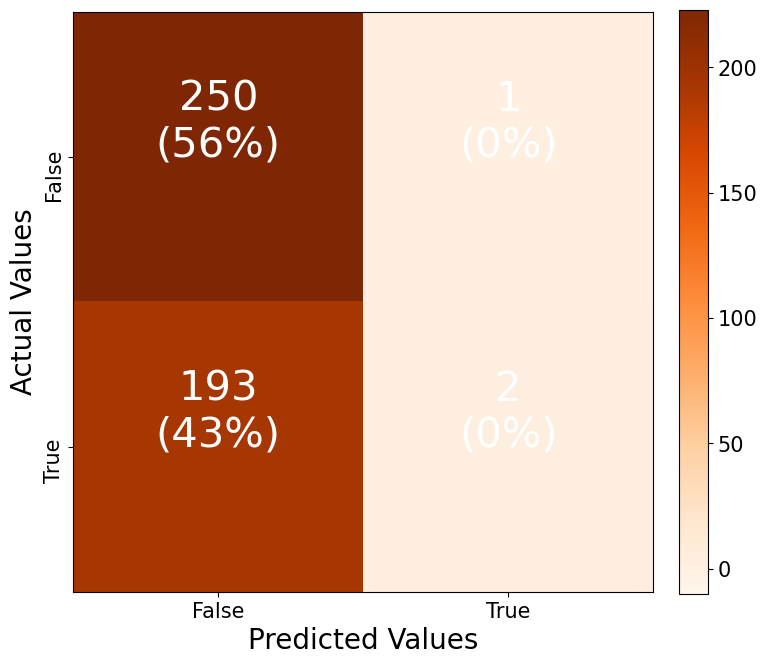

"\n# for evaluating ensemble... for 446 test set..\nACCs['ensemble'] = {}\nmodel_name = 'vgg16_ensemble'\ntrain_strategy = 'finetuning'\nauroc_color = 'Blue'\nconfusion_color = plt.cm.Blues\ngroups = ['ALL', 'AGE1','AGE2','AGE3','AGE4', 'FEMALE', 'MALE']\nfor group in groups:\n    ACCs['ensemble'][group] = {}\n    proba = (vgg16proba_with_clinicdata['PD'][train_strategy]['test']['proba'] + vgg16proba_with_clinicdata['T2'][train_strategy]['test']['proba'])/2\n    label = vgg16proba_with_clinicdata['PD'][train_strategy]['test']['label']\n    clinic = vgg16proba_with_clinicdata['PD'][train_strategy]['test']['clinic']\n    expert = vgg16proba_with_clinicdata[MRI][train_strategy]['test']['expert']\n    \n    if group != 'ALL':\n        clinic, proba, label, expert = get_filtered_result(clinic, proba, label, expert, filter_standard = 'sexage')\n    save = True\n    auroc_save_path     = f'''./Figures/AUROC_{model_name}_{train_strategy}_{group}.png'''\n    confusion_save_path = f'''./Figures/

In [31]:
model_name = 'vgg16'
#model_name = 'resnet50'

ACCs = {}
# for evaluating Vgg16... for 446 test set..

ACCs[model_name] = {}
for MRI in MRIs:
    ACCs[model_name][MRI] = {}
    for train_strategy in train_strategies:
        ACCs[model_name][MRI][train_strategy] = {}
        #if train_strategy == 'finetuning' : groups = ['ALL']#, 'AGE1','AGE2','AGE3', 'AGE4', 'FEMALE', 'MALE']
        if 1 ==1 : groups = ['ALL']
        #else : groups = [model_name]
        for group in groups:
            ACCs[model_name][MRI][train_strategy][group] = {}
            # for evaluating vgg16... for 446 test set..
            proba = vgg16proba_with_clinicdata[MRI][train_strategy]['test']['proba'][:,0]
            label = vgg16proba_with_clinicdata[MRI][train_strategy]['test']['label'][:,0]
            clinic = vgg16proba_with_clinicdata[MRI][train_strategy]['test']['clinic']
            expert = vgg16proba_with_clinicdata[MRI][train_strategy]['test']['expert']
            
            if group != 'ALL':
                clinic, proba, label, expert = get_filtered_result(clinic, proba, label, expert, filter_standard = 'sexage')
                
            save = True
            auroc_save_path     = f'''./Figures/AUROC_{model_name}_{MRI}_{train_strategy}_{group}.png'''
            confusion_save_path = f'''./Figures/CONFUSION_{model_name}_{MRI}_{train_strategy}_{group}.png'''

            if train_strategy == 'finetuning' : 
                auroc_color = 'Blue'
                confusion_color = plt.cm.Blues
            if train_strategy == 'fromscratch': 
                auroc_color = 'Green'
                confusion_color = plt.cm.Greens
            if train_strategy == 'freeze':
                auroc_color = 'Orange'
                confusion_color = plt.cm.Oranges
                
            auroc, threshold, accuracy = plot_roc_curve(label, proba, '', size=(8,8), color = auroc_color, save = save, save_path = auroc_save_path)
            ACCs[model_name][MRI][train_strategy][group]['proba'] = proba
            ACCs[model_name][MRI][train_strategy][group]['clinic'] = clinic
            ACCs[model_name][MRI][train_strategy][group]['label'] = label
            ACCs[model_name][MRI][train_strategy][group]['acc'] = accuracy
            ACCs[model_name][MRI][train_strategy][group]['n_pt'] = len(proba)
            
            pred = decision_func(proba, threshold=threshold)
            conf_mat = confusion_matrix(label, pred)
            padd_plot_confusion_matrix(figsize = (8,8), conf_matrix = conf_mat,xlabel = 'Predicted Values', x_labels=['False','True'], ylabel = 'Actual Values', y_labels=['False','True'], color = confusion_color, save= save, save_path = confusion_save_path)
            ACCs[model_name][MRI][train_strategy][group]['pred'] = pred
    
    
"""
# for evaluating ensemble... for 446 test set..
ACCs['ensemble'] = {}
model_name = 'vgg16_ensemble'
train_strategy = 'finetuning'
auroc_color = 'Blue'
confusion_color = plt.cm.Blues
groups = ['ALL', 'AGE1','AGE2','AGE3','AGE4', 'FEMALE', 'MALE']
for group in groups:
    ACCs['ensemble'][group] = {}
    proba = (vgg16proba_with_clinicdata['PD'][train_strategy]['test']['proba'] + vgg16proba_with_clinicdata['T2'][train_strategy]['test']['proba'])/2
    label = vgg16proba_with_clinicdata['PD'][train_strategy]['test']['label']
    clinic = vgg16proba_with_clinicdata['PD'][train_strategy]['test']['clinic']
    expert = vgg16proba_with_clinicdata[MRI][train_strategy]['test']['expert']
    
    if group != 'ALL':
        clinic, proba, label, expert = get_filtered_result(clinic, proba, label, expert, filter_standard = 'sexage')
    save = True
    auroc_save_path     = f'''./Figures/AUROC_{model_name}_{train_strategy}_{group}.png'''
    confusion_save_path = f'''./Figures/CONFUSION_{model_name}_{train_strategy}_{group}.png'''
    
    
    auroc, threshold, accuracy = plot_roc_curve(label, proba, '', size=(8,8), color = auroc_color, save = save, save_path = auroc_save_path)
    ACCs['ensemble'][group]['proba'] = proba
    ACCs['ensemble'][group]['clinic'] = clinic
    ACCs['ensemble'][group]['label'] = label
    ACCs['ensemble'][group]['acc']  = accuracy
    ACCs['ensemble'][group]['n_pt'] = len(proba)
    
    pred = decision_func(proba, threshold=threshold)
    conf_mat = confusion_matrix(label, pred)
    padd_plot_confusion_matrix(figsize = (8,8), conf_matrix = conf_mat,x_labels=['False','True'], y_labels=['False','True'], color = confusion_color, save= save, save_path = confusion_save_path)
    ACCs['ensemble'][group]['pred'] = pred

    
    
# for evaluating shallow_three_layer_network.
ACCs['STL'] = {}
model_name = 'STL'
auroc_color = 'Blue'
confusion_color = plt.cm.Blues
groups = ['ALL', 'AGE1','AGE2','AGE3','AGE4', 'FEMALE', 'MALE']
for MRI in MRIs:
    ACCs['STL'][MRI] = {}
    for group in groups:
        ACCs['STL'][MRI][group] = {}
        proba = STLproba_with_clinicdata[MRI]['test']['proba']
        label = STLproba_with_clinicdata[MRI]['test']['label']
        clinic = STLproba_with_clinicdata[MRI]['test']['clinic']
        expert = STLproba_with_clinicdata[MRI]['test']['expert']

        if group != 'ALL':
            clinic, proba, label, expert = get_filtered_result(clinic, proba, label, expert, filter_standard = 'sexage')
        save = True
        auroc_save_path     = f'''./Figures/AUROC_{model_name}_{train_strategy}_{group}.png'''
        confusion_save_path = f'''./Figures/CONFUSION_{model_name}_{train_strategy}_{group}.png'''

        
        auroc, threshold, accuracy = plot_roc_curve(label, proba, '', size=(8,8), color = auroc_color, save = save, save_path = auroc_save_path)
        ACCs['STL'][MRI][group]['proba'] = proba
        ACCs['STL'][MRI][group]['clinic'] = clinic
        ACCs['STL'][MRI][group]['label'] = label
        ACCs['STL'][MRI][group]['acc']  = accuracy
        ACCs['STL'][MRI][group]['n_pt'] = len(proba)

        pred = decision_func(proba, threshold=threshold)
        conf_mat = confusion_matrix(label, pred)
        padd_plot_confusion_matrix(figsize = (8,8), conf_matrix = conf_mat,x_labels=['False','True'], y_labels=['False','True'], color = confusion_color, save= save, save_path = confusion_save_path)
        ACCs['STL'][MRI][group]['pred'] = pred
    
    
# for evaluating expert..
ACCs['expert'] = {}

model_name = 'expert'
train_strategy = 'finetuning'
auroc_color = 'Blue'
confusion_color = plt.cm.Blues
groups = ['ALL', 'AGE1','AGE2','AGE3','AGE4', 'FEMALE', 'MALE']
for group in groups:
    ACCs['expert'][group] = {}
    proba = vgg16proba_with_clinicdata['PD'][train_strategy]['test']['proba']
    label = vgg16proba_with_clinicdata['PD'][train_strategy]['test']['label']
    clinic = vgg16proba_with_clinicdata['PD'][train_strategy]['test']['clinic']
    expert = vgg16proba_with_clinicdata['PD'][train_strategy]['test']['expert']
    
    if group != 'ALL':
        clinic, proba, label, expert = get_filtered_result(clinic, proba, label, expert, filter_standard = 'sexage')
    save = True
    auroc_save_path     = f'''./Figures/AUROC_{model_name}_{train_strategy}_{group}.png'''
    confusion_save_path = f'''./Figures/CONFUSION_{model_name}_{train_strategy}_{group}.png'''
    
    
    auroc, threshold, accuracy = plot_roc_curve(label, expert, '', size=(8,8), color = auroc_color, save = save, save_path = auroc_save_path)
    ACCs['expert'][group]['expert'] = expert
    ACCs['expert'][group]['clinic'] = clinic
    ACCs['expert'][group]['label'] = label
    ACCs['expert'][group]['acc'] = accuracy
    ACCs['expert'][group]['n_pt']= len(proba)
    
    pred = decision_func(expert, threshold=threshold)
    conf_mat = confusion_matrix(label, pred)
    padd_plot_confusion_matrix(figsize = (8,8), conf_matrix = conf_mat,x_labels=['False','True'], y_labels=['False','True'], color = confusion_color, save= save, save_path = confusion_save_path)
    ACCs['expert'][group]['pred]']= pred
"""        